##### Importing the Dataset

In [315]:
import pandas as pd
import numpy as np
import pyodbc
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.tree import export_text
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



conn = pyodbc.connect(r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=..\Data\go_sales_schoon.accdb;')
cursor = conn.cursor()
#WHY THE FUCK DOES ACCESS REQUIRE BRACKETS FOR MORE THAN ONE JOIN AND WHY DIT IT TAKE SO LONG FOR ME TO FIND THIS INFO REEEEEEEEEEEEEEEEEEEEE
sql = """
SELECT *
FROM (returned_item
INNER JOIN return_reason
ON returned_item.RETURN_REASON_CODE = return_reason.RETURN_REASON_CODE)
INNER JOIN order_details
ON returned_item.ORDER_DETAIL_CODE = order_details.ORDER_DETAIL_CODE
"""
cursor.execute(sql)
data = cursor.fetchall()

columns = [column[0] for column in cursor.description]

formatted_data = {}

for i in range(len(columns)):
    dataList = []
    for j in data:
        dataList.append(j[i])
    formatted_data[columns[i]] = dataList

df = pd.DataFrame(data=formatted_data,columns=columns)
df

,RETURN_CODE,RETURN_DATE,ORDER_DETAIL_CODE,RETURN_REASON_CODE,RETURN_QUANTITY,RETURN_REASON_CODE,RETURN_DESCRIPTION_EN,ORDER_DETAIL_CODE,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE
0,1576,17-4-2021 01:04:14,48713,4,152,4,Wrong product shipped,48713,1219,29,152,41.77,71.02,71.02
1,1579,17-4-2021 03:08:50,48733,2,12,2,Incomplete product,48733,1273,31,144,7.8,15.6,13.64
2,1584,2-12-2021 14:36:03,48769,1,24,1,Defective product,48769,1547,35,264,18.42,24.86,23.04
3,1587,10-3-2021 16:41:11,48861,1,2,1,Defective product,48861,1492,47,34,43.77,63.49,58.56
4,2233,15-4-2021 21:54:01,48902,2,2,2,Incomplete product,48902,1245,52,30,18.35,36.7,36.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,2036,3-9-2021 22:57:06,102556,2,2,2,Incomplete product,102556,8567,74,34,11.43,16.02,16.02
702,2037,21-4-2021 06:15:01,102578,1,4,1,Defective product,102578,8553,77,50,45.31,90.63,83.84
703,2038,28-6-2021 12:31:55,102592,2,2,2,Incomplete product,102592,8644,79,12,98.98,133.63,128.42
704,2040,11-11-2021 02:05:46,102628,4,18,4,Wrong product shipped,102628,8673,84,18,81.23,113.73,113.73


##### Extracting Datasets

In [316]:
x = df.drop(columns=["RETURN_DESCRIPTION_EN","RETURN_DATE","ORDER_DETAIL_CODE","RETURN_CODE","ORDER_NUMBER"]) #Bit cheaty ,"RETURN_REASON_CODE"

y = df["RETURN_DESCRIPTION_EN"]

feature_names = x.columns

labels = y.unique()


X_train, test_x, y_train, test_lab = train_test_split(x, y,test_size=0.4, random_state=42)

x

,RETURN_REASON_CODE,RETURN_QUANTITY,RETURN_REASON_CODE,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE
0,4,152,4,29,152,41.77,71.02,71.02
1,2,12,2,31,144,7.8,15.6,13.64
2,1,24,1,35,264,18.42,24.86,23.04
3,1,2,1,47,34,43.77,63.49,58.56
4,2,2,2,52,30,18.35,36.7,36.7
...,...,...,...,...,...,...,...,...
701,2,2,2,74,34,11.43,16.02,16.02
702,1,4,1,77,50,45.31,90.63,83.84
703,2,2,2,79,12,98.98,133.63,128.42
704,4,18,4,84,18,81.23,113.73,113.73


Now that we have the data in the right format, we will build the decision tree in order to anticipate how the different flowers will be classified. The first step is to import the DecisionTreeClassifier package from the sklearn library. 

##### Importing Decision Tree Classifier

The max depth argument controls the tree's maximum depth. We use this to ensure that no overfitting is done and that we can simply see how the final result was obtained. The random state parameter assures that the results are repeatable in subsequent investigations.

##### Fitting Algorithm to Training Data

In [317]:
clf = DecisionTreeClassifier(max_depth = 4, random_state = 42)

clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

We want to be able to understand how the algorithm works, and one of the benefits of employing a decision tree classifier is that the output is simple to comprehend and visualize.

##### Checking the Algorithms

We can do this using the following two ways:

    1. As a tree diagram
    2. As a text-based diagram

Let us now see the detailed implementation of these:

##### 1. Tree diagram

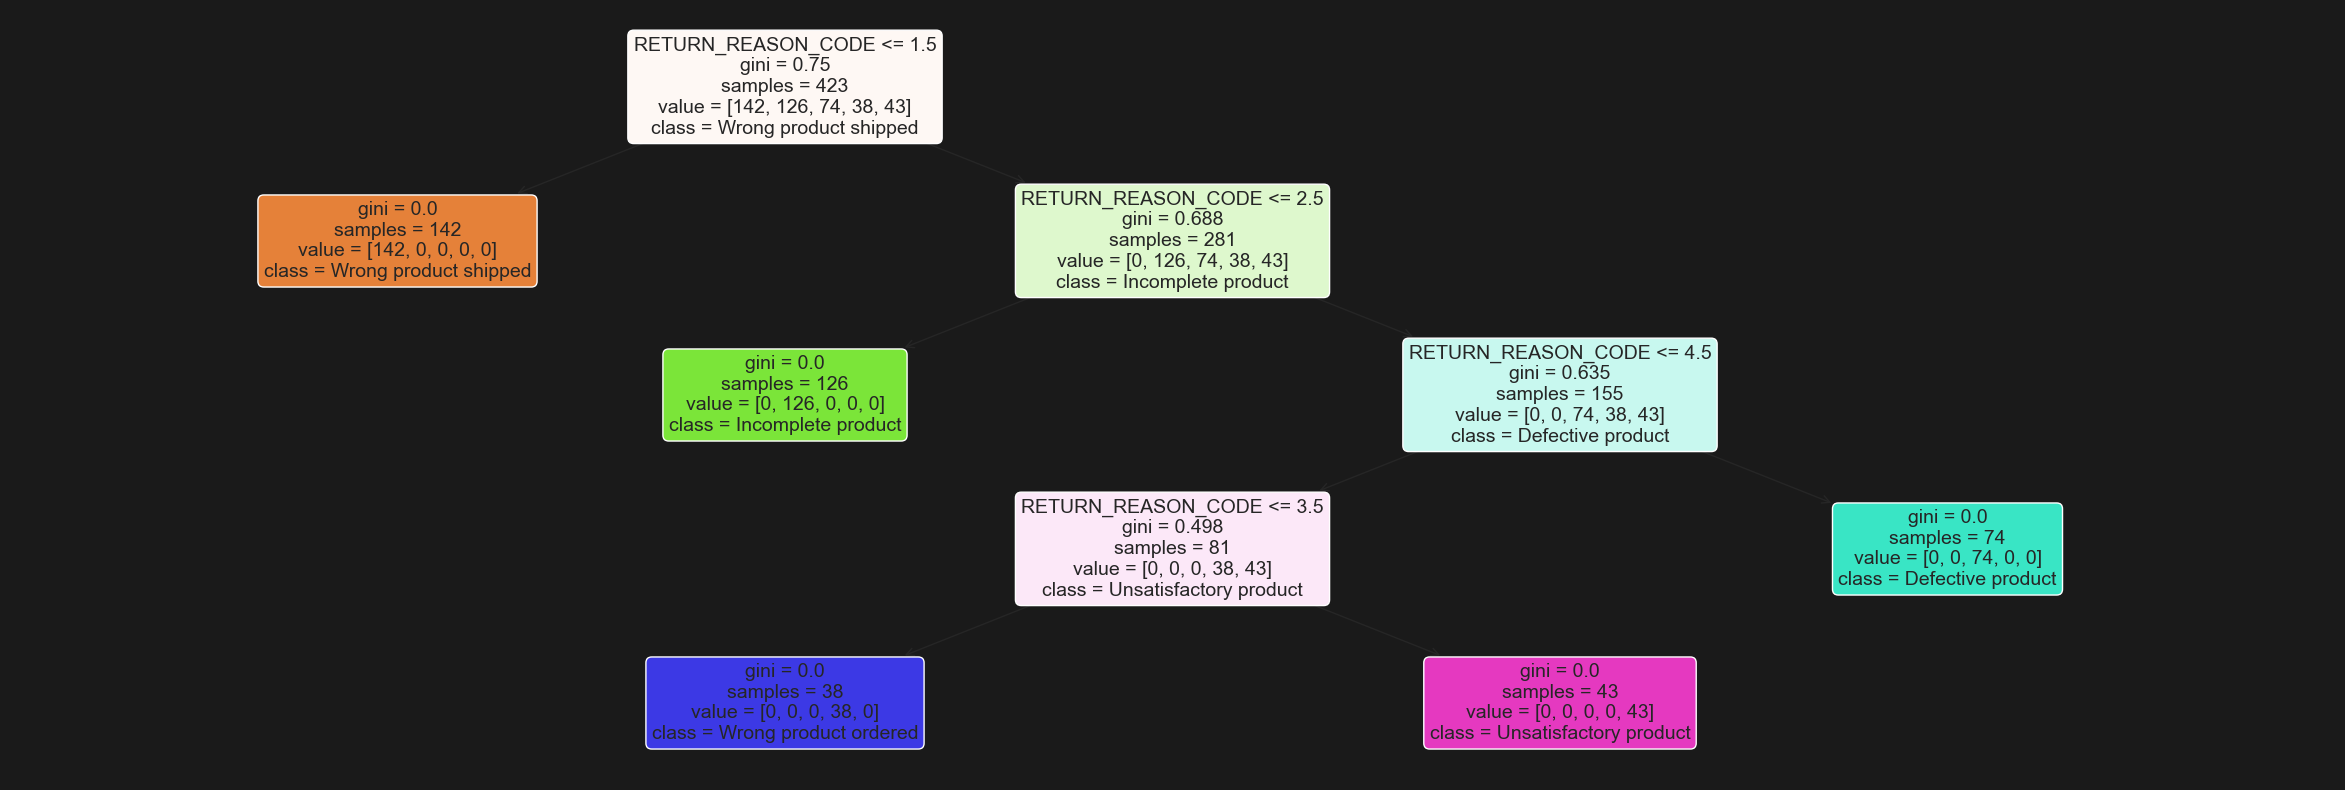

In [318]:
plt.figure(figsize=(30,10), facecolor ='k')
a = tree.plot_tree(clf, feature_names = feature_names, class_names = labels, rounded = True, filled = True, fontsize=14)
plt.show()

##### 2. As a Text-Based Diagram

In [319]:
tree_rules = export_text(clf, feature_names = list(feature_names))
print(tree_rules)

|--- RETURN_REASON_CODE <= 1.50
|   |--- class: Defective product
|--- RETURN_REASON_CODE >  1.50
|   |--- RETURN_REASON_CODE <= 2.50
|   |   |--- class: Incomplete product
|   |--- RETURN_REASON_CODE >  2.50
|   |   |--- RETURN_REASON_CODE <= 4.50
|   |   |   |--- RETURN_REASON_CODE <= 3.50
|   |   |   |   |--- class: Wrong product ordered
|   |   |   |--- RETURN_REASON_CODE >  3.50
|   |   |   |   |--- class: Wrong product shipped
|   |   |--- RETURN_REASON_CODE >  4.50
|   |   |   |--- class: Unsatisfactory product



##### Predict Class From Unknown Test Values

In [320]:
test_pred_decision_tree = clf.predict(test_x)

##### Make and format a confusion matrix

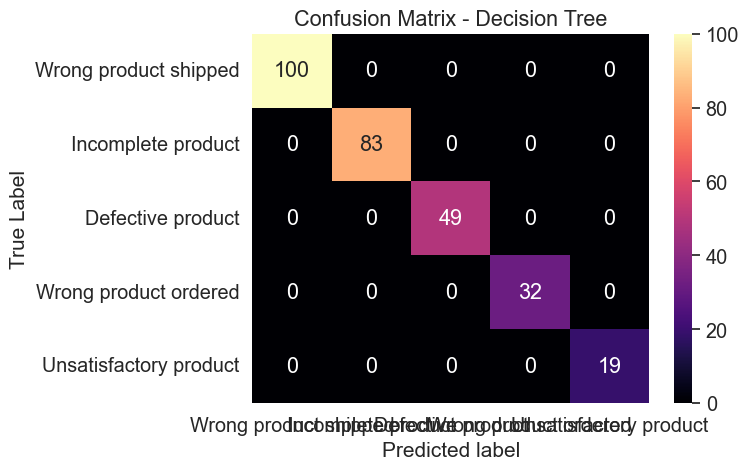

<Figure size 1000x700 with 0 Axes>

In [321]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(test_lab, test_pred_decision_tree)
matrix_df = pd.DataFrame(confusion_matrix)

ax = plt.axes()

sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
ax.set_title('Confusion Matrix - Decision Tree')
ax.set_xlabel("Predicted label", fontsize =15)
ax.set_xticklabels(['']+labels)
ax.set_ylabel("True Label", fontsize=15)
ax.set_yticklabels(list(labels), rotation = 0)

plt.show()

In the output above, only one value from the Iris-versicolor class has failed from being predicted from the unseen data. This indicates that this algorithm has done a good job at predicting unseen data overall.